In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data and Main Variables

In [60]:
models = ["jinaai/jina-embeddings-v3",
           "Snowflake/snowflake-arctic-embed-l-v2.0", "BAAI/bge-m3", 
           'sentence-transformers/all-MiniLM-L6-v2', 
           'sentence-transformers/all-mpnet-base-v2', 
           'Qwen/Qwen3-Embedding-0.6B', 'google/embeddinggemma-300m']

In [136]:
EMBEDDING_COLUMN = models[0]
AGGREGATION_VARIABLE = "eu_party"
df = pd.read_parquet("data/speech_embeddings.parquet")
vocab_df = pd.read_parquet("data/vocab_embeddings (1).parquet")

In [137]:
df = df[(df['text'].str.len() < 1_300) & (df['text'].str.len() > 700)]

# Helper Functions

In [138]:
def get_aggregated_embeddings_for_year(df: pd.DataFrame, embedding_column: str, aggregate_on: str, year: int):
    year_subset = df[pd.to_datetime(df['date']).dt.year == year]
    aggregated_embeddings = year_subset.groupby(by=aggregate_on)[embedding_column].agg(lambda emb: np.stack(emb).mean(axis=0) )
    return aggregated_embeddings.reset_index()
get_aggregated_embeddings_for_year(df, embedding_column=EMBEDDING_COLUMN, aggregate_on=AGGREGATION_VARIABLE, year=2015)

,eu_party,jinaai/jina-embeddings-v3
0,ALDE,"[0.048580572, -0.10238109, 0.06577023, 0.03254..."
1,ECR,"[0.038850933, -0.11541268, 0.06453439, 0.02325..."
2,EFDD,"[0.040956426, -0.11579274, 0.076389454, 0.0129..."
3,ENF,"[0.041636657, -0.11317546, 0.0508077, 0.025760..."
4,GUE/NGL,"[0.04265398, -0.10382952, 0.06761947, 0.023213..."
5,Greens/EFA,"[0.049150623, -0.11216612, 0.07473672, 0.01784..."
6,PPE,"[0.040518016, -0.10949234, 0.067367874, 0.0253..."
7,S&D,"[0.046698198, -0.09988138, 0.07731309, 0.02468..."


In [139]:
def get_aggregated_embeddings_for_each_year(df: pd.DataFrame, embedding_column: str, aggregate_on: str):
    yearly_data = df.copy()
    yearly_data['year'] = pd.to_datetime(df['date']).dt.year
    aggregated_embeddings = yearly_data.groupby(by=[aggregate_on, 'year'])[embedding_column].agg(lambda emb: np.stack(emb).mean(axis=0) )
    return aggregated_embeddings.reset_index()
get_aggregated_embeddings_for_each_year(df, embedding_column=EMBEDDING_COLUMN, aggregate_on=AGGREGATION_VARIABLE)

,eu_party,year,jinaai/jina-embeddings-v3
0,ALDE,2005,"[0.015014648, -0.09423828, 0.033203125, -0.005..."
1,ALDE,2006,"[0.028076172, -0.11376953, 0.11279297, -0.0502..."
2,ALDE,2007,"[0.017913818, -0.14013672, 0.050964355, 0.0136..."
3,ALDE,2008,"[0.07165527, -0.09586588, 0.05525716, 0.086995..."
4,ALDE,2009,"[0.04511719, -0.100976564, 0.09013672, 0.03028..."
...,...,...,...
173,UEN,2004,"[0.0074157715, -0.09033203, 0.04345703, 0.1015..."
174,UEN,2006,"[0.050048828, -0.14355469, 0.06201172, -0.0668..."
175,UEN,2007,"[0.027832031, -0.13671875, 0.03515625, 0.04565..."
176,UEN,2008,"[0.041931152, -0.09375, 0.072387695, 0.0475769..."


# Patterns over time

## PCA based shifts

In [140]:
from sklearn.decomposition import PCA


aggregate_on = "eu_party"
aggregated = get_aggregated_embeddings_for_each_year(df, EMBEDDING_COLUMN, aggregate_on)
pca = PCA(n_components=2)
reduced = pca.fit_transform(np.stack(aggregated[EMBEDDING_COLUMN]))
pca.explained_variance_.sum()

np.float32(0.020718616)

In [141]:
pca.components_.shape

(2, 1024)

In [142]:
vocab_df[EMBEDDING_COLUMN].iloc[0].shape

(1024,)

In [157]:
import re
vocab = list(df['text'].str.split().explode().apply(lambda word: {"cleared": re.sub(r'\W+', '', word).lower(),
                                                                      "original": word}))

In [161]:
cleaned_to_original = {pair['cleared']: pair['original'] for pair in vocab}

In [163]:
cleaned_to_original['rohingya']

'Rohingya'

In [ ]:
def closest_words_for_pc(k, eigen_vectors, vocab, probe_embs, top_n=20):
    pc_vec = eigen_vectors[k]
    pc_vec = pc_vec / np.linalg.norm(pc_vec)

    sims = probe_embs @ pc_vec   

    pos_idx = np.argsort(sims)[-top_n:]
    neg_idx = np.argsort(sims)[:top_n]

    print(f"\n=== PC{k+1} ===")
    print("Positive side:")
    for i in reversed(pos_idx):
        print(f"{vocab[i]:>25} | sim={sims[i]: .3f}")

    print("\nNegative side:")
    for i in neg_idx:
        print(f"{vocab[i]:>25} | sim={sims[i]: .3f}")

closest_words_for_pc(0, pca.components_, vocab_df['word'], np.stack(vocab_df[EMBEDDING_COLUMN]), top_n=15)

# unhcr UN refugee agency


=== PC1 ===
Positive side:
                    unhcr | sim= 0.238
                 rohingya | sim= 0.237
   resettlementprogrammes | sim= 0.232
                rohingyas | sim= 0.232
             asylumseeker | sim= 0.215
                  refuges | sim= 0.213
            asylumseekers | sim= 0.209
            asylumrelated | sim= 0.209
            asylumseeking | sim= 0.209
               readoption | sim= 0.205
                  refugee | sim= 0.199
                   refuge | sim= 0.195
            resettlements | sim= 0.193
                 accepted | sim= 0.191
                   unhcrs | sim= 0.190

Negative side:
       crossmediterranean | sim=-0.278
            euroimbeciles | sim=-0.258
             mediterranea | sim=-0.239
             mediterranée | sim=-0.237
             eurosceptics | sim=-0.237
             méditerranée | sim=-0.233
             mediterraneo | sim=-0.233
        euromediterranean | sim=-0.229
              europeanism | sim=-0.228
                    

In [144]:
closest_words_for_pc(1, pca.components_, vocab_df['word'], np.stack(vocab_df[EMBEDDING_COLUMN]), top_n=10)



=== PC2 ===
Positive side:
                illegally | sim= 0.306
                  illegal | sim= 0.288
                  illicit | sim= 0.252
               illegality | sim= 0.239
       illegalimmigration | sim= 0.238
             legalization | sim= 0.220
               foreigners | sim= 0.212
                 illegals | sim= 0.212
                 nonlegal | sim= 0.212
                legalized | sim= 0.212

Negative side:
                  refuges | sim=-0.303
                  asylums | sim=-0.285
                   asylum | sim=-0.283
                  asylumo | sim=-0.281
                  asyluma | sim=-0.275
                   refuge | sim=-0.273
            asylumrelated | sim=-0.270
                  asylumb | sim=-0.262
                refugeesʼ | sim=-0.257
          asylumproducing | sim=-0.249


In [151]:
color_map = {
    # Social-democratic / centre-left
    "PSE": "#E41A1C",      # red – classic social-democrats
    "S&D": "#D62728",      # modern centre-left red

    # Green / regionalist
    "Greens/EFA": "#32CD32",   # bright ecological green

    # Liberal / centrist
    "ALDE": "#FFD700",     # gold – liberal-centrist
    "ELDR": "#FFC300",     # yellow – predecessor of ALDE
    "Renew": "#F2C400",    # Renew Europe → ALDE lineage; slightly softer gold

    # Conservative / Christian-democratic / centre-right
    "PPE": "#1F77B4",      # royal blue – centre-right
    "PPE-DE": "#1E90FF",   # lighter center-right
    "UEN": "#F4D03F",      # yellow-ish soft right/Christian-democratic

    # Right-wing Eurosceptic / conservative-nationalist
    "ECR": "#0057A4",      # deep conservative blue
    "IND/DEM": "#6A5ACD",  # purple – right-wing eurosceptic
    "EFD": "#7B68EE",      # medium purple – eurosceptic
    "EFDD": "#9370DB",     # softer purple – populist eurosceptic
    "EDD": "#8A2BE2",      # violet – early eurosceptic right

    # Far-right / nationalist
    "ITS": "#00008B",      # dark navy – far-right
    "ENF": "#000080",      # navy – nationalist far-right
    "ID": "#806000",       # earthy brown – Identity & Democracy

    # Left / far-left
    "The Left": "#8B0000", # deep dark red – consistent with GUE/NGL lineage
    "GUE/NGL": "#8B0000",  # far-left red
}



## Combined

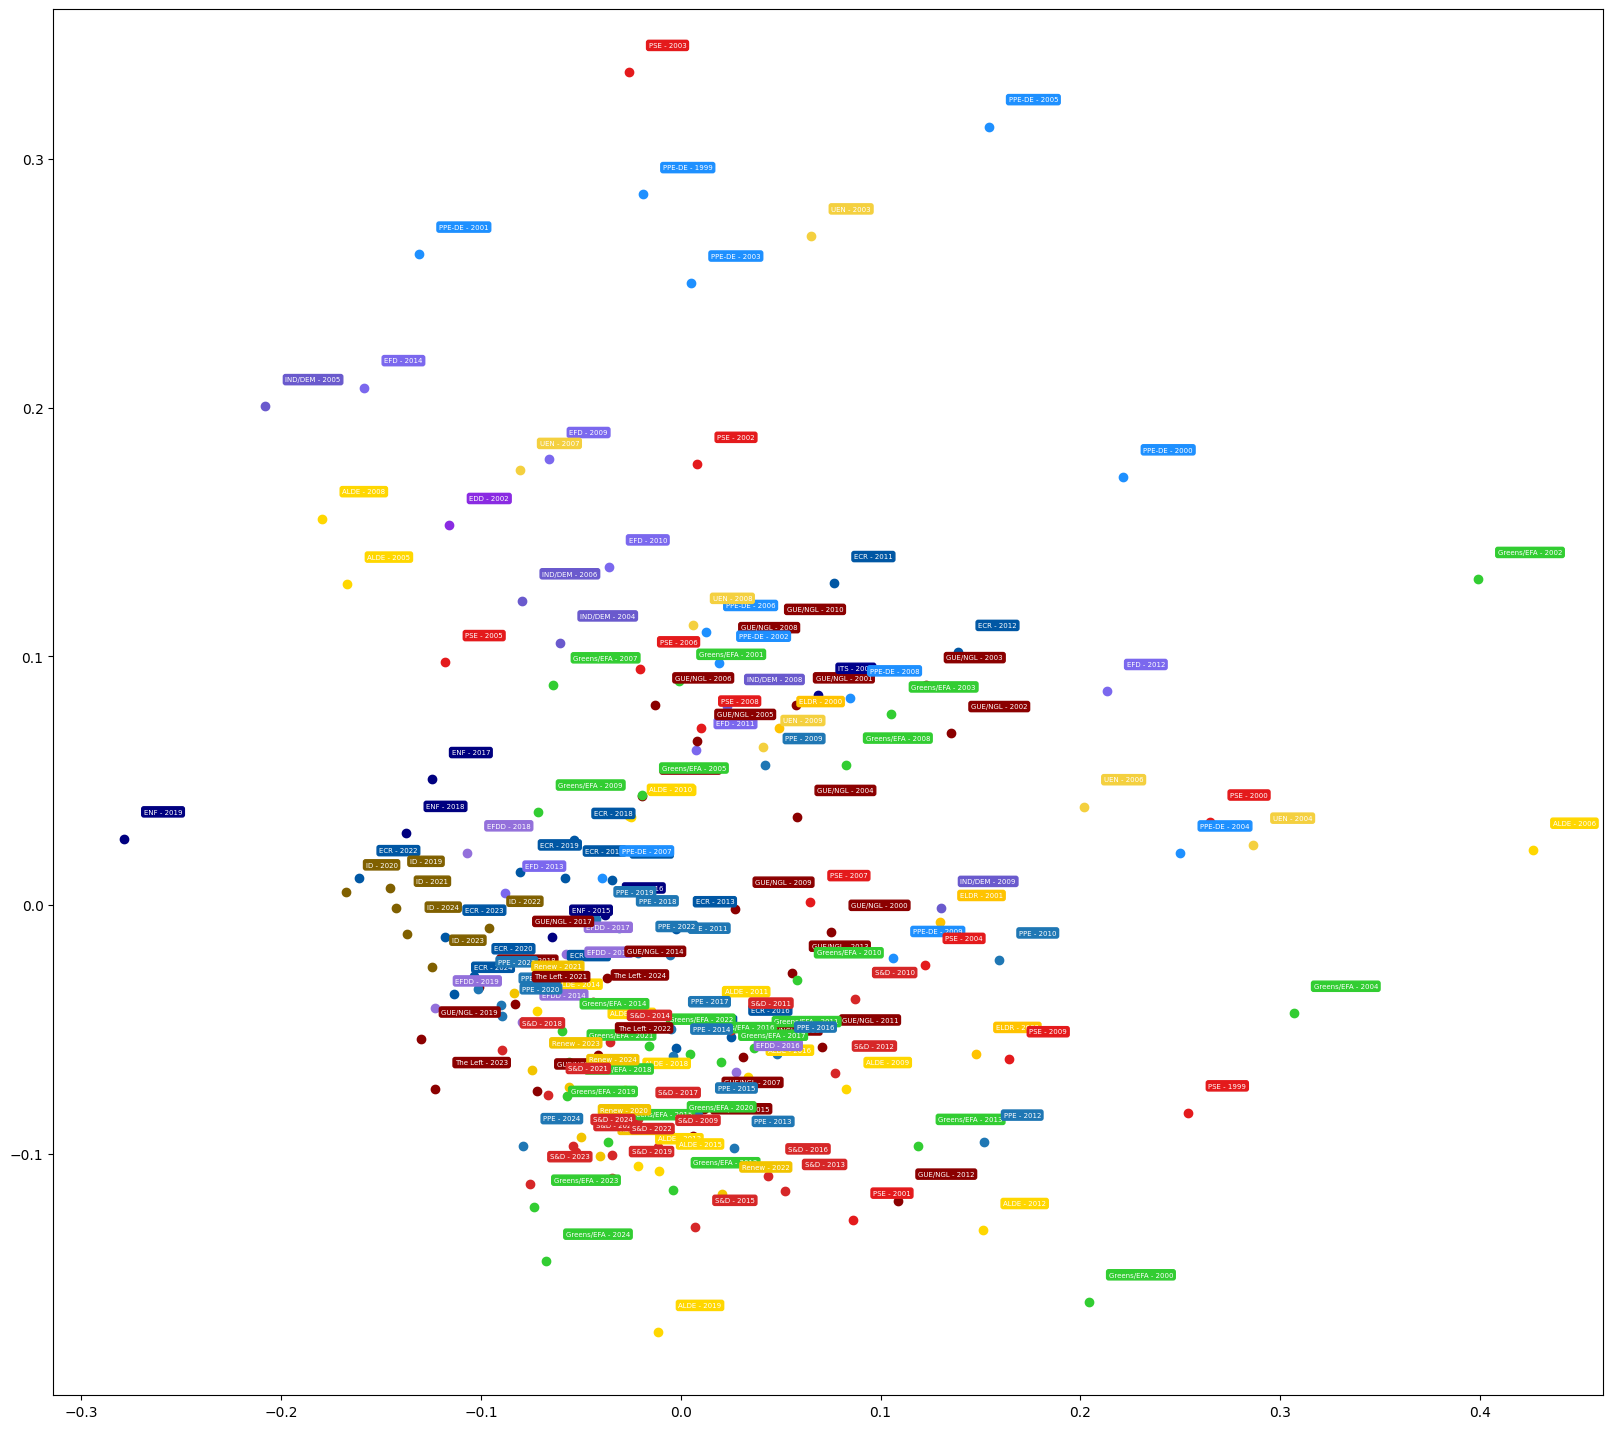

In [153]:
plt.figure(figsize=(20, 18))
for party in aggregated[aggregate_on].unique():
    party_mask = aggregated[aggregate_on] == party
    years = aggregated[party_mask]['year']
    party_embeddings = reduced[party_mask]
    plt.scatter(party_embeddings[:, 0], party_embeddings[:, 1], marker='o', color=color_map[party])
    for i, year in enumerate(years):
      plt.text(party_embeddings[i,0]+0.01, party_embeddings[i,1]+0.01, f"{party} - {year}", fontsize=5, bbox=dict(boxstyle="round", color=color_map[party]), color='white')


## Individual

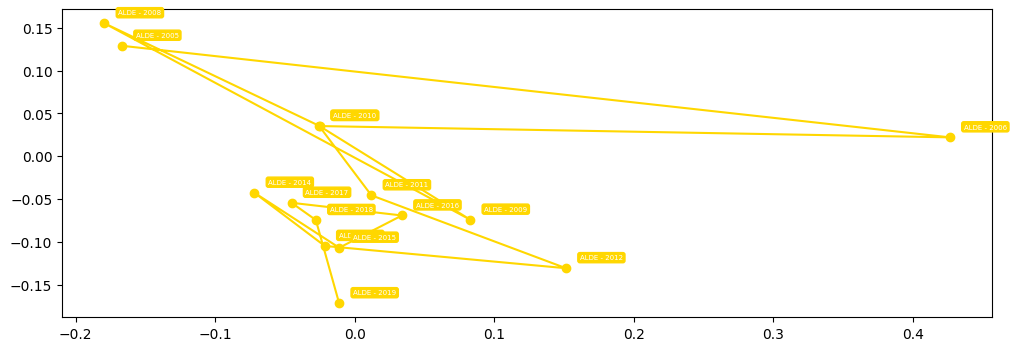

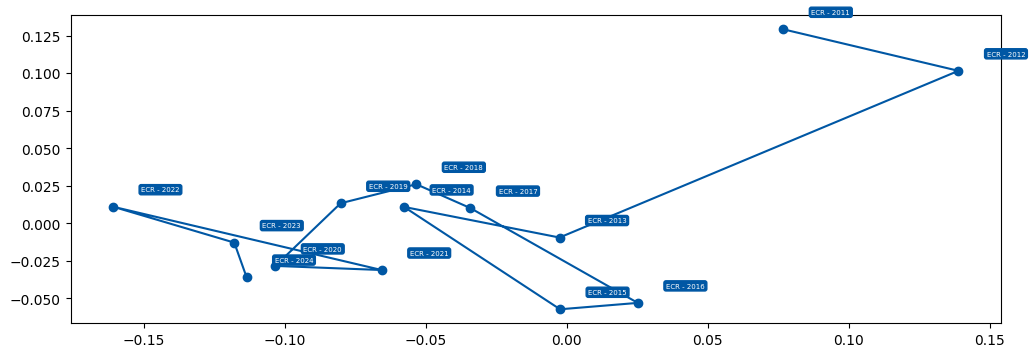

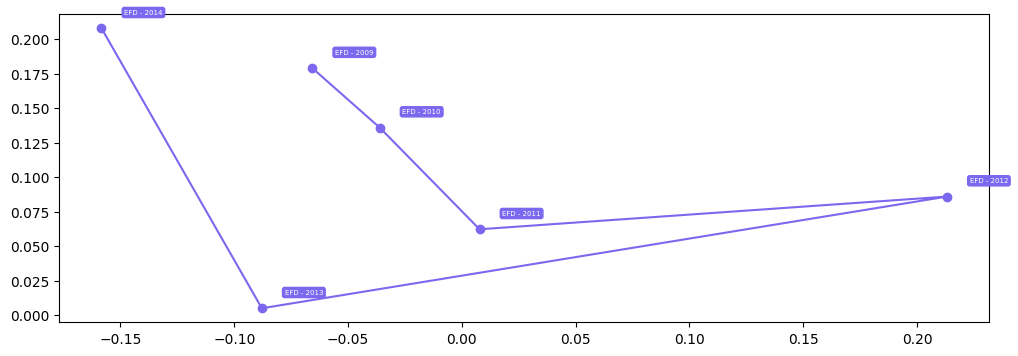

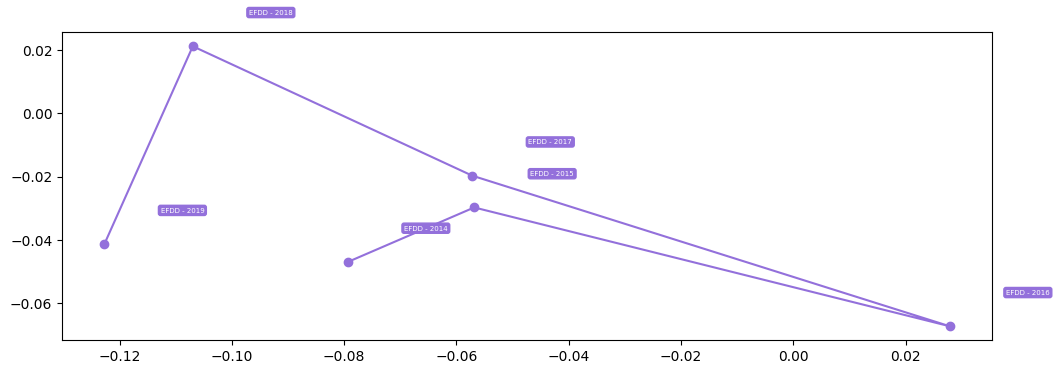

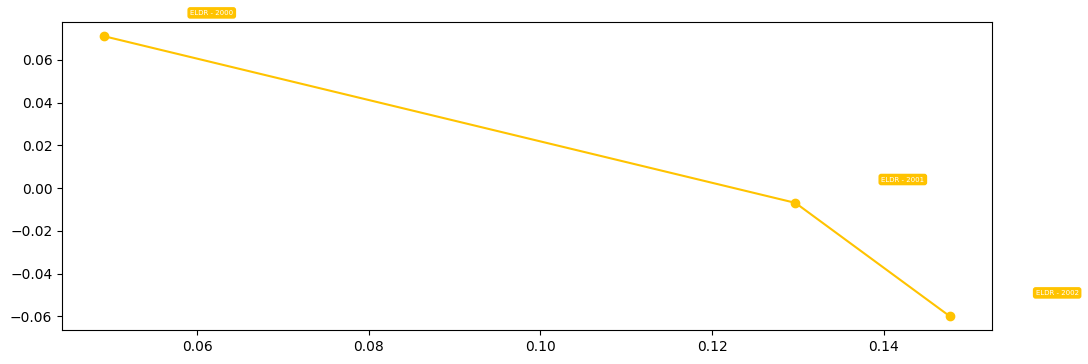

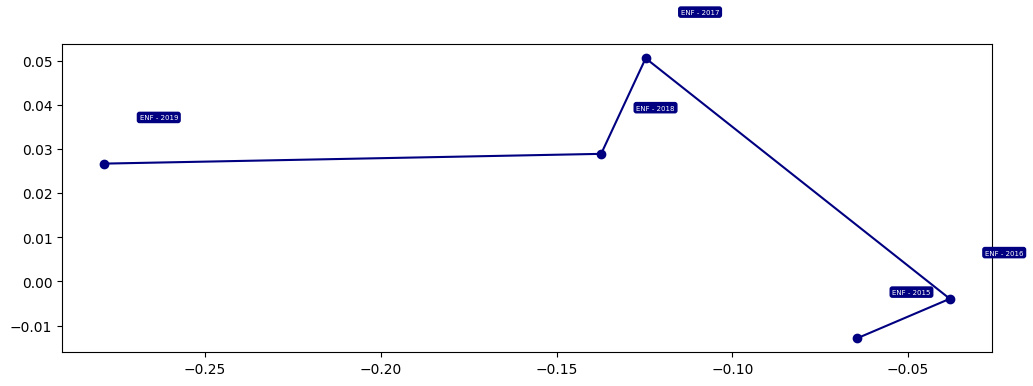

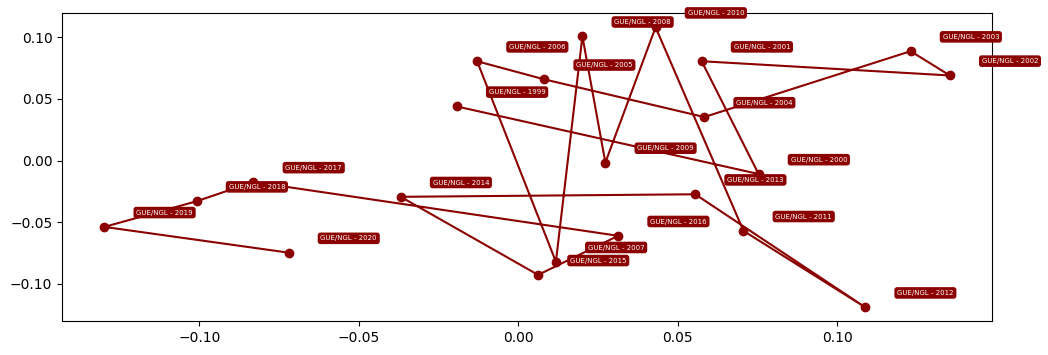

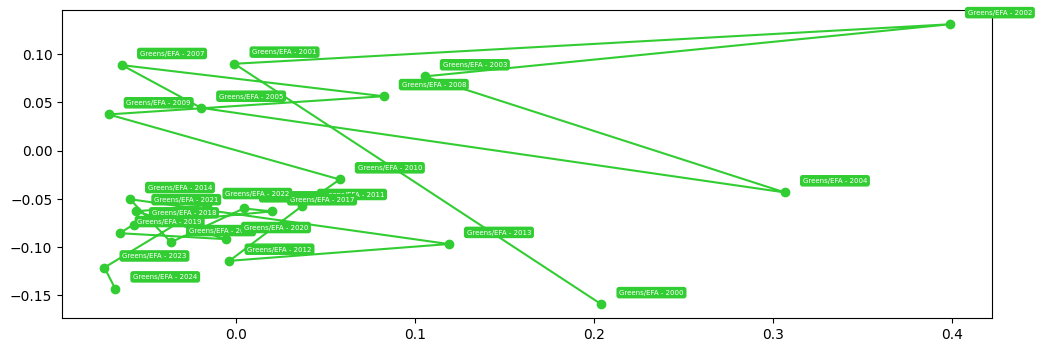

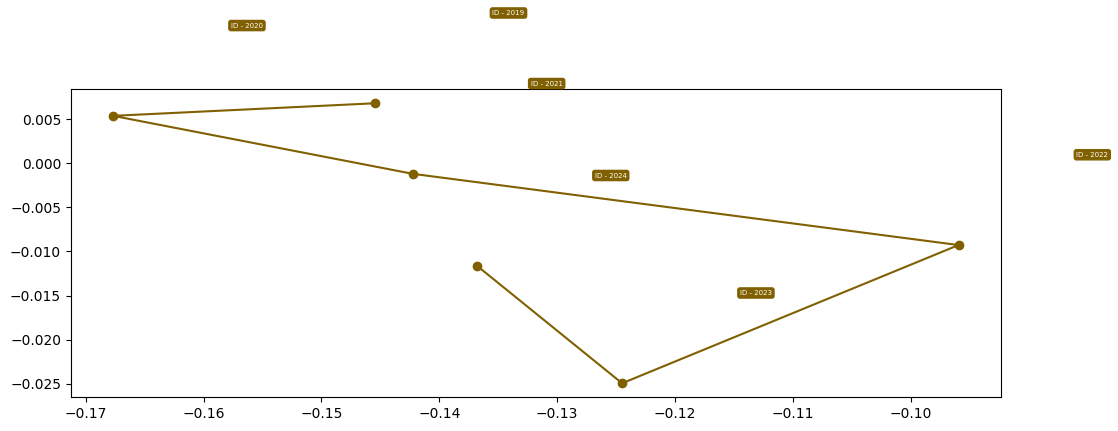

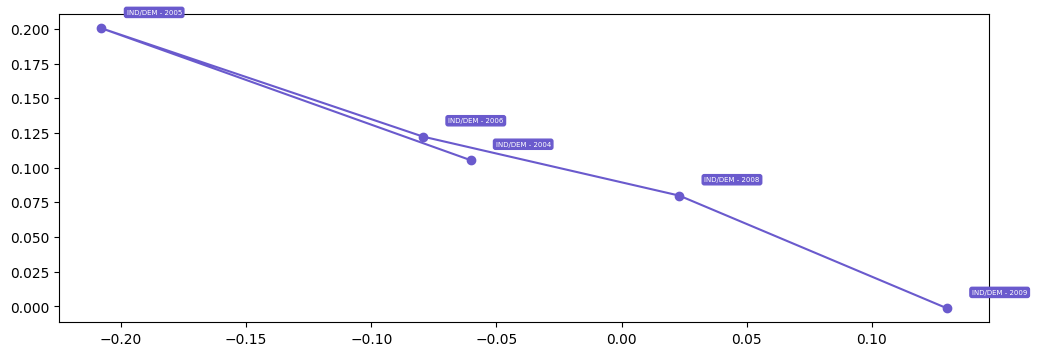

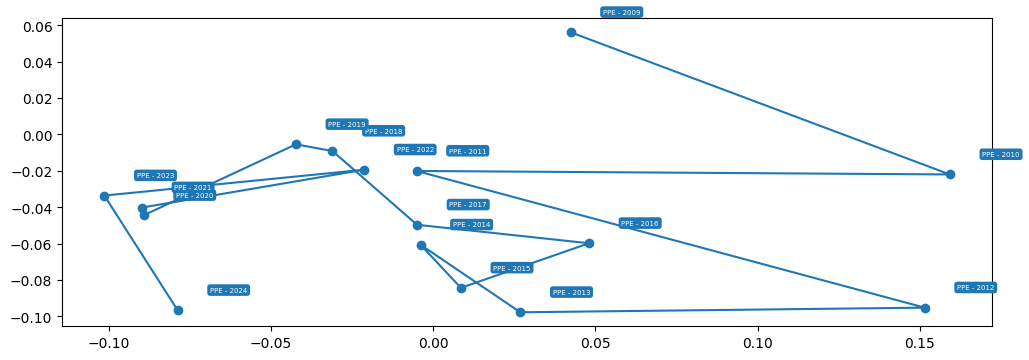

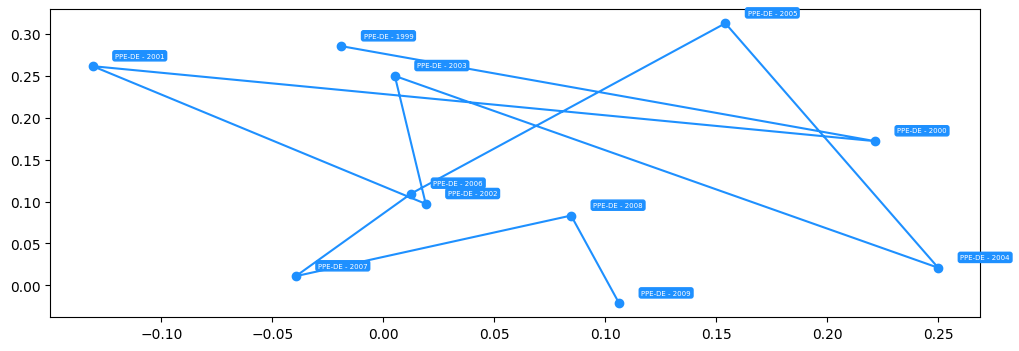

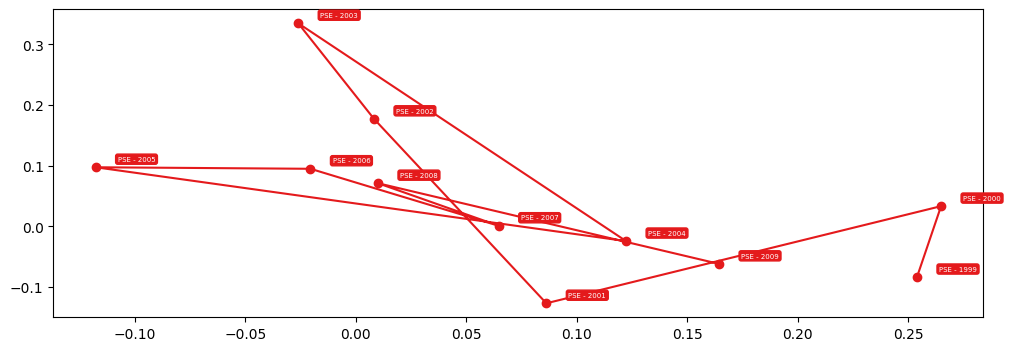

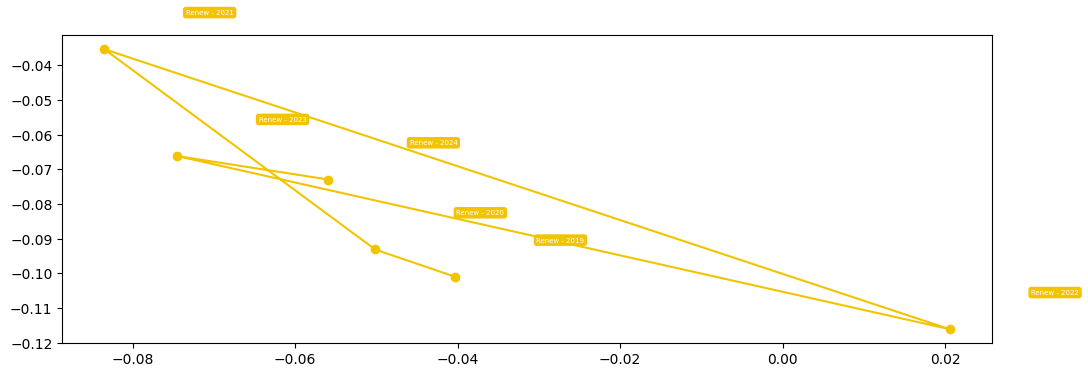

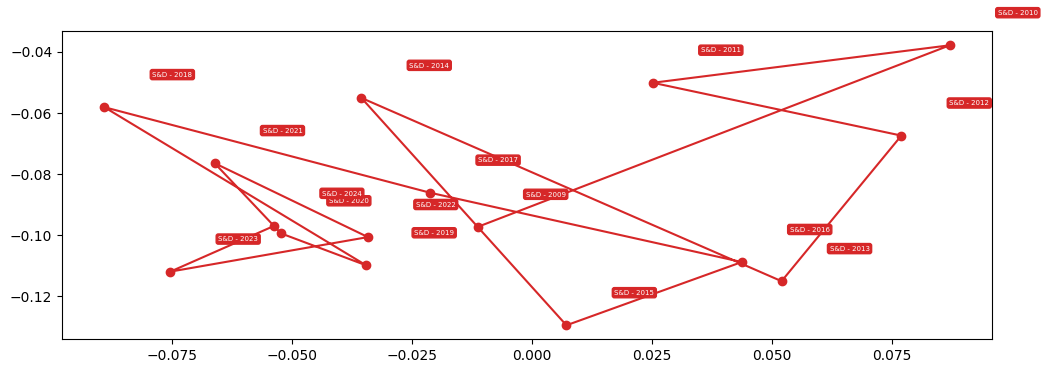

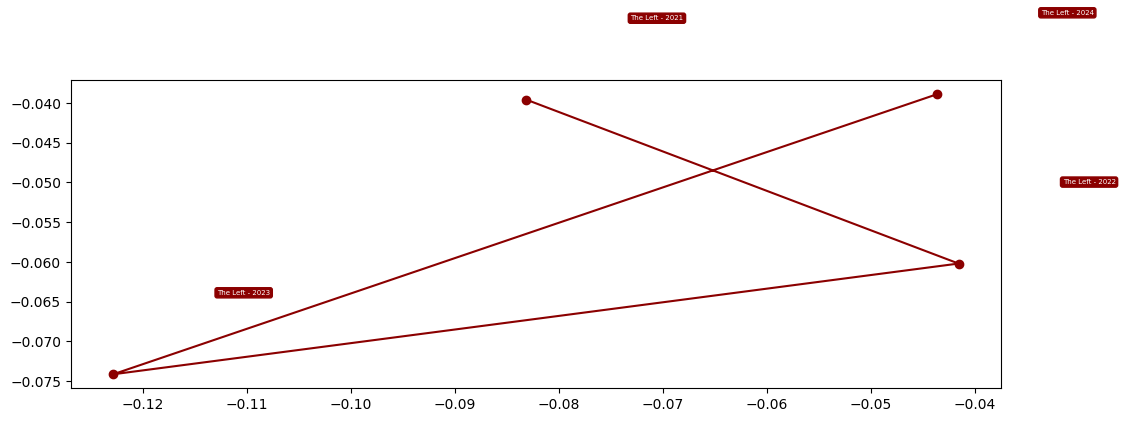

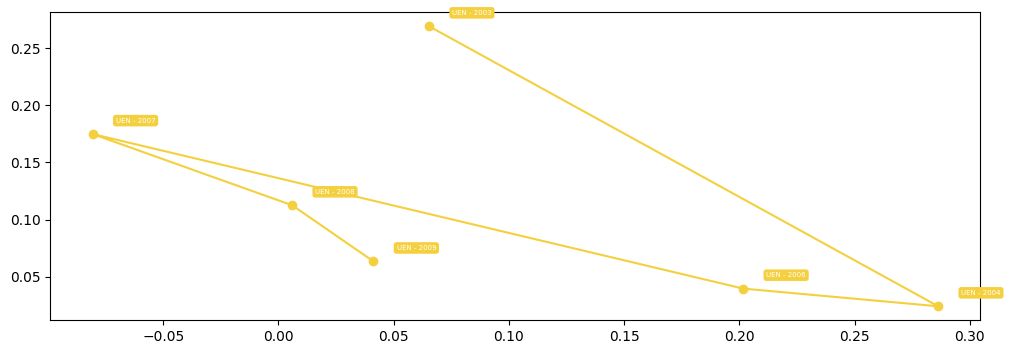

In [154]:
for party in aggregated[aggregate_on].unique():
    
    party_mask = aggregated[aggregate_on] == party
    years = aggregated[party_mask]['year']
    if len(years) < 2:
       continue
    fig, ax = plt.subplots(figsize=(12, 4))
    party_embeddings = reduced[party_mask]
    ax.plot(party_embeddings[:, 0], party_embeddings[:, 1], marker='o', color=color_map[party])
    for i, year in enumerate(years):
      ax.text(party_embeddings[i,0]+0.01, party_embeddings[i,1]+0.01, f"{party} - {year}", fontsize=5, bbox=dict(boxstyle="round", color=color_map[party]), color='white')


## Ideological Distance over the years

### Ideological Shift

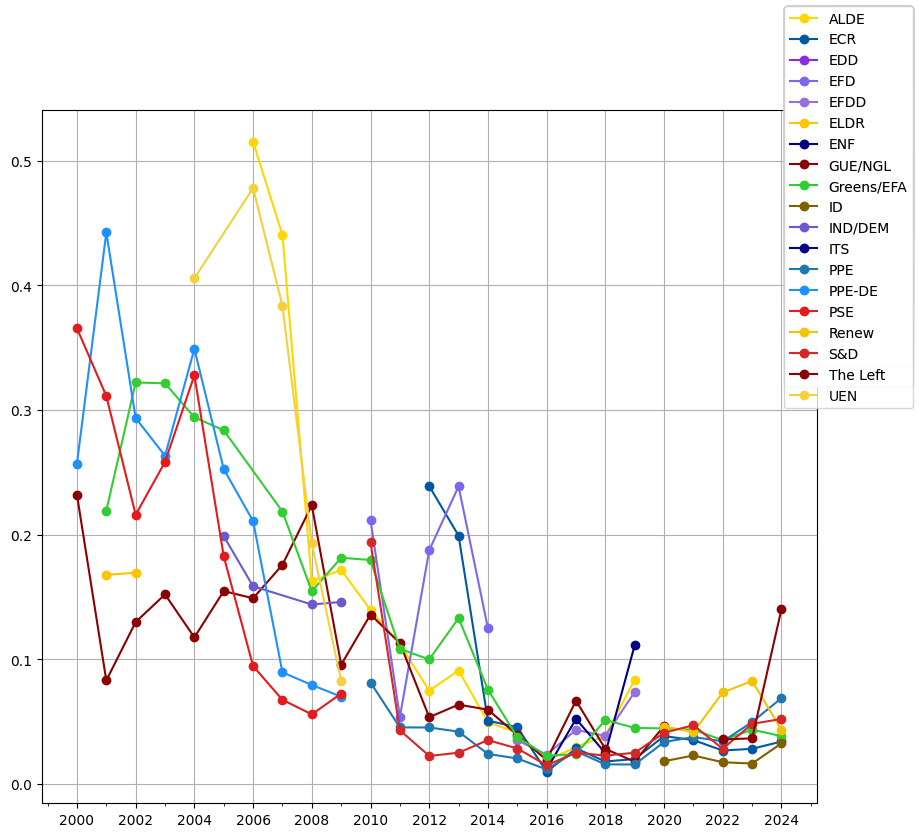

In [164]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot()
for party in aggregated[aggregate_on].unique():
    party_mask = aggregated[aggregate_on] == party
    years = aggregated[party_mask]['year']
    party_embeddings = np.stack(aggregated[EMBEDDING_COLUMN][party_mask])
    cos_sim = (party_embeddings[:-1] * party_embeddings[1: ]).sum(axis=1) / (np.linalg.norm(party_embeddings[:-1], axis=1) * np.linalg.norm(party_embeddings[1:], axis=1))
    cos_distance = 1 - cos_sim
    plt.plot(years[1:], cos_distance, marker='o',  label=party, color=color_map[party])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    fig.legend()
    ax.grid()
    


### Ideological Closeness

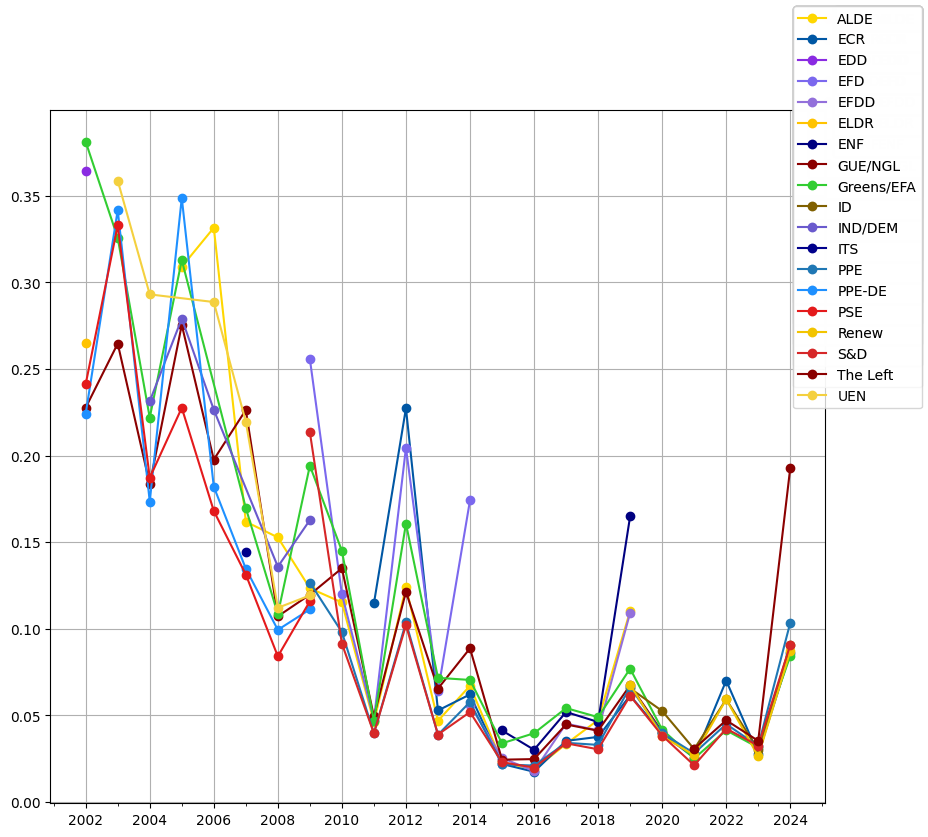

In [165]:
import matplotlib.ticker as ticker
from torch.nn.functional import cosine_similarity
import torch

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot()
aggregated = aggregated[aggregated['year'] > 2001]
for party in aggregated[aggregate_on].unique():
    party_mask = aggregated[aggregate_on] == party
    years = aggregated[party_mask]['year']
    party_embeddings = np.stack(aggregated[EMBEDDING_COLUMN][party_mask])
    other_parties = aggregated[~party_mask]
    cos_distances = []
    for idx, year in enumerate(years):
        curr_party_embedding = party_embeddings[idx]
        other_party_embeddings = np.stack(other_parties[other_parties['year'] == year][EMBEDDING_COLUMN])
        cos_sim = cosine_similarity(torch.from_numpy(other_party_embeddings), torch.from_numpy(curr_party_embedding))
        cos_distance = 1 - cos_sim
        cos_distances.append(cos_distance.mean())

    plt.plot(years, cos_distances, marker='o',  label=party, color=color_map[party])
    ax.grid()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    fig.legend()
    